In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
import torch.optim as optim
from torchinfo import summary
#from torch.utils.data import Dataset, DataLoader
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math, copy, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

import numpy as np
import networkx as nx

In [2]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphConv

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
    legend2 = plt.legend(handles, labels, loc="upper right", title="Class")
    plt.show()

In [3]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

# Data from GNN Explainer: 
https://github.com/RexYing/gnn-model-explainer

In [3]:
def ba(start, width, role_start=0, m=5):
    """Builds a BA preferential attachment graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    width       :    int size of the graph
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.barabasi_albert_graph(width, m)
    graph.add_nodes_from(range(start, start + width))
    nids = sorted(graph)
    mapping = {nid: start + i for i, nid in enumerate(nids)}
    graph = nx.relabel_nodes(graph, mapping)
    roles = [role_start for i in range(width)]
    return graph, roles


def house(start, role_start=0):
    """Builds a house-like  graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from(
        [
            (start, start + 1),
            (start + 1, start + 2),
            (start + 2, start + 3),
            (start + 3, start),
        ]
    )
    # graph.add_edges_from([(start, start + 2), (start + 1, start + 3)])
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1, role_start + 1, role_start + 2]
    return graph, roles

def build_graph(
    width_basis,
    basis_type,
    list_shapes,
    start=0,
    rdm_basis_plugins=False,
    add_random_edges=0,
    m=5,
):
    """This function creates a basis (scale-free, path, or cycle)
    and attaches elements of the type in the list randomly along the basis.
    Possibility to add random edges afterwards.
    INPUT:
    --------------------------------------------------------------------------------------
    width_basis      :      width (in terms of number of nodes) of the basis
    basis_type       :      (torus, string, or cycle)
    shapes           :      list of shape list (1st arg: type of shape,
                            next args:args for building the shape,
                            except for the start)
    start            :      initial nb for the first node
    rdm_basis_plugins:      boolean. Should the shapes be randomly placed
                            along the basis (True) or regularly (False)?
    add_random_edges :      nb of edges to randomly add on the structure
    m                :      number of edges to attach to existing node (for BA graph)
    OUTPUT:
    --------------------------------------------------------------------------------------
    basis            :      a nx graph with the particular shape
    role_ids         :      labels for each role
    plugins          :      node ids with the attached shapes
    """
    if basis_type == "ba":
        basis, role_id = eval(basis_type)(start, width_basis, m=m)
    else:
        basis, role_id = eval(basis_type)(start, width_basis)

    n_basis, n_shapes = nx.number_of_nodes(basis), len(list_shapes)
    start += n_basis  # indicator of the id of the next node

    # Sample (with replacement) where to attach the new motifs
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(n_basis / n_shapes)
        plugins = [int(k * spacing) for k in range(n_shapes)]
    seen_shapes = {"basis": [0, n_basis]}

    for shape_id, shape in enumerate(list_shapes):
        shape_type = shape[0]
        args = [start]
        if len(shape) > 1:
            args += shape[1:]
        args += [0]
        graph_s, roles_graph_s = eval(shape_type)(*args)
        n_s = nx.number_of_nodes(graph_s)
        try:
            col_start = seen_shapes[shape_type][0]
        except:
            col_start = np.max(role_id) + 1
            seen_shapes[shape_type] = [col_start, n_s]
        # Attach the shape to the basis
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        basis.add_edges_from([(start, plugins[shape_id])])
        if shape_type == "cycle":
            if np.random.random() > 0.5:
                a = np.random.randint(1, 4)
                b = np.random.randint(1, 4)
                basis.add_edges_from([(a + start, b + plugins[shape_id])])
        temp_labels = [r + col_start for r in roles_graph_s]
        # temp_labels[0] += 100 * seen_shapes[shape_type][0]
        role_id += temp_labels
        start += n_s

    if add_random_edges > 0:
        # add random edges between nodes:
        for p in range(add_random_edges):
            src, dest = np.random.choice(nx.number_of_nodes(basis), 2, replace=False)
            print(src, dest)
            basis.add_edges_from([(src, dest)])

    return basis, role_id, plugins

46 47
43 29
48 68


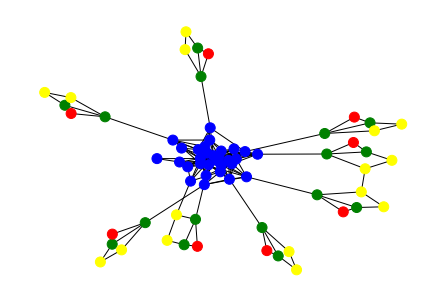

In [5]:
ba_shapes1, role_ids1, plugins1 = build_graph(
    30,
    "ba",
    [["house"]]*8,
    start=0,
    rdm_basis_plugins=True,
    add_random_edges=3,
    m=5,
)
pos1 = nx.spring_layout(ba_shapes1, seed=42)
color_dict1 = {0:"blue", 1:"green", 2:"yellow", 3:"red"}
nx.draw(ba_shapes1, pos1, node_color=[color_dict1[i] for i in role_ids1], node_size=100)

In [4]:
ba_shapes, role_ids, plugins = build_graph(
    300,
    "ba",
    [["house"]]*80,
    start=0,
    rdm_basis_plugins=True,
    add_random_edges=30,
    m=5,
)

33 256
183 312
348 51
75 594
409 504
566 312
180 468
496 348
539 314
696 634
359 666
534 88
67 548
647 580
496 189
483 33
39 102
359 644
657 50
559 618
334 503
561 284
338 64
47 561
196 258
668 80
656 338
547 330
377 339
675 165


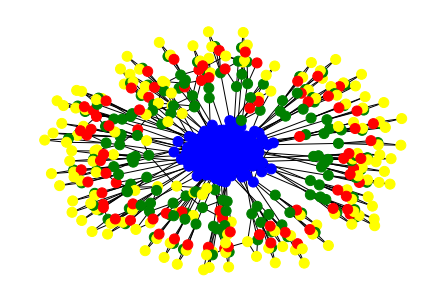

In [5]:
pos = nx.spring_layout(ba_shapes, seed=42)
color_dict = {0:"blue", 1:"green", 2:"yellow", 3:"red"}
nx.draw(ba_shapes, pos, node_color=[color_dict[i] for i in role_ids], node_size=100)

## Dataset: 
https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/ba_shapes.html#BAShapes

In [11]:
edge_index = torch.tensor(list(ba_shapes1.edges), dtype=torch.long).T.contiguous()
num_nodes = ba_shapes1.number_of_nodes()
x = torch.ones((num_nodes, 10), dtype=torch.float)
y = torch.tensor(role_ids1, dtype=torch.long)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[torch.arange(30,40)] = True
train_mask[np.setdiff1d(torch.arange(40, num_nodes),torch.arange(40, num_nodes, 3))] = True
test_mask[torch.arange(40, num_nodes, 3)] = True
data1 = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
data1

Data(x=[70, 10], edge_index=[2, 183], y=[70], train_mask=[70], test_mask=[70])

In [6]:
edge_index = torch.tensor(list(ba_shapes.edges), dtype=torch.long).T.contiguous()
num_nodes = ba_shapes.number_of_nodes()
x = torch.ones((num_nodes, 10), dtype=torch.float)
y = torch.tensor(role_ids, dtype=torch.long)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[torch.arange(300,400)] = True
train_mask[np.setdiff1d(torch.arange(400, num_nodes),torch.arange(400, num_nodes, 3))] = True
test_mask[torch.arange(400, num_nodes, 3)] = True
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
data

Data(x=[700, 10], edge_index=[2, 2064], y=[700], train_mask=[700], test_mask=[700])

In [104]:
edge_index = torch.tensor(list(ba_shapes.edges) + [(y,x) for x,y in list(ba_shapes.edges)],
                          dtype=torch.long).T.contiguous()
num_nodes = ba_shapes.number_of_nodes()
x = torch.ones((num_nodes, 10), dtype=torch.float)
y = torch.tensor(role_ids, dtype=torch.long)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
#train_mask[torch.arange(300,400)] = True
train_mask[np.setdiff1d(torch.arange(300, num_nodes),torch.arange(400, num_nodes, 3))] = True
test_mask[torch.arange(400, num_nodes, 3)] = True
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
data

Data(x=[700, 10], edge_index=[2, 4128], y=[700], train_mask=[700], test_mask=[700])

In [8]:
train_mask.sum(), test_mask.sum()

(tensor(300), tensor(100))

In [88]:
#loader = DataLoader(data, batch_size=32, shuffle=True)

In [124]:
# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures
# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [125]:
# data = dataset[0]

In [105]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 700
Number of edges: 4128
Average node degree: 5.90
Number of training nodes: 300
Training node label rate: 0.43
Has isolated nodes: False
Has self-loops: False
Is undirected: True


# Model

In [20]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return x #F.log_softmax(x, dim=1)

In [106]:
class GCN2(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GraphConv(num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return x #F.log_softmax(x, dim=1)

In [33]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, heads=8):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=heads, concat=False)
        self.conv2 = GATConv(hidden_channels, num_classes, heads=1) 

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Planetoid code from:
https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=pcr9joFQ6Mri

D:\Anaconda3\envs\torch_fish_env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda3\envs\torch_fish_env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


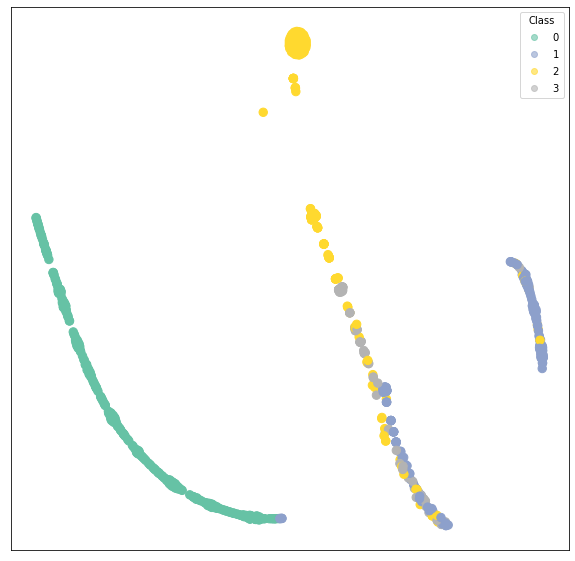

In [107]:
model = GCN2(num_node_features=data.num_features, hidden_channels=12, num_classes=np.unique(y).shape[0])
#model = GAT(num_node_features=data.num_features, hidden_channels=8, num_classes=np.unique(y).shape[0])
model.eval()

out = model(data)
visualize(out, color=data.y)

In [108]:
#model = GCN(num_node_features=data.num_features, hidden_channels=12, num_classes=np.unique(y).shape[0])
#model = GAT(num_node_features=data.num_features, hidden_channels=2, num_classes=np.unique(y).shape[0])
model = GCN2(num_node_features=data.num_features, hidden_channels=12, num_classes=np.unique(y).shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test(mask):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return acc

min_acc = 0
counter = 0
for epoch in range(1, 10001):
    loss = train()
    #val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    print(f'\rEpoch: {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}', end="")
#     if min_acc < val_acc:
#         min_acc = val_acc
#         counter = 0
#     else:
#         counter += 1
#     if counter == 20:
#         break

Epoch: 10000, Loss: 0.3981, Test: 0.9600

In [109]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9600


D:\Anaconda3\envs\torch_fish_env\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda3\envs\torch_fish_env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


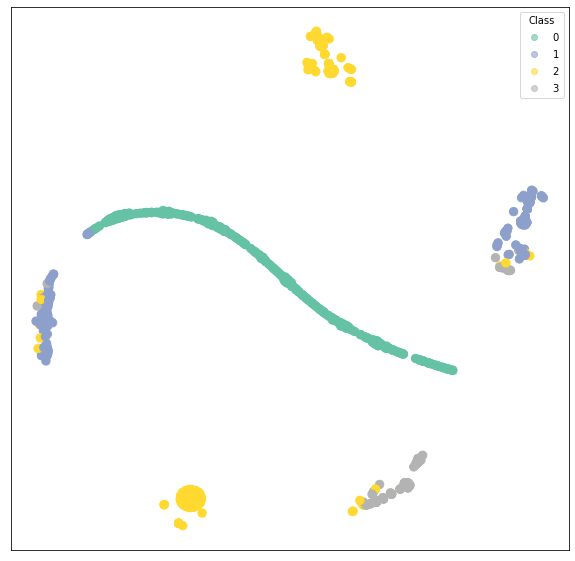

In [110]:
model.eval()

out = model(data)
visualize(out, color=data.y)

# Train

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=10, num_classes=np.unique(y).shape[0]).to(device)
data1 = data1.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model.train()
for epoch in range(20):
    print(f"epoch {epoch}/200", end="\r")
    optimizer.zero_grad()
    out = model(data1)
    loss = F.nll_loss(out[data1.train_mask], data1.y[data1.train_mask])
    loss.backward()
    optimizer.step()

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=10, num_classes=np.unique(y).shape[0]).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model.train()
for epoch in range(200):
    print(f"epoch {epoch}/200", end="\r")
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Test

In [21]:
with torch.no_grad():
    model.eval()
    pred = model(data1).argmax(dim=1)
    correct = (pred[data1.train_mask] == data1.y[data1.train_mask]).sum()
    acc = int(correct) / int(data1.train_mask.sum())
    print('Train Accuracy: {:.4f}'.format(acc))

Train Accuracy: 0.4000


In [22]:
with torch.no_grad():
    model.eval()
    pred = model(data1).argmax(dim=1)
    correct = (pred[data1.test_mask] == data1.y[data1.test_mask]).sum()
    acc = int(correct) / int(data1.test_mask.sum())
    print('Test Accuracy: {:.4f}'.format(acc))

Test Accuracy: 0.4000


In [23]:
pred

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

In [19]:
data1.y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 1, 1, 2, 2, 3, 1, 1, 2, 2, 3, 1, 1, 2,
        2, 3, 1, 1, 2, 2, 3, 1, 1, 2, 2, 3, 1, 1, 2, 2, 3, 1, 1, 2, 2, 3],
       device='cuda:0')

In [111]:
from sklearn.metrics import classification_report

In [112]:
with torch.no_grad():
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc = int(correct) / int(data.train_mask.sum())
    print('Train Accuracy: {:.4f}'.format(acc))
    print(classification_report(data.y[data.train_mask], pred[data.train_mask]))

Train Accuracy: 0.9267
              precision    recall  f1-score   support

           1       0.89      0.99      0.94       120
           2       0.99      0.86      0.92       120
           3       0.90      0.93      0.92        60

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.92       300
weighted avg       0.93      0.93      0.93       300



In [113]:
with torch.no_grad():
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print('Test Accuracy: {:.4f}'.format(acc))
    print(classification_report(data.y[data.test_mask], pred[data.test_mask]))

Test Accuracy: 0.9600
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        40
           2       0.97      0.95      0.96        40
           3       0.90      0.90      0.90        20

    accuracy                           0.96       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.96      0.96      0.96       100



In [114]:
color_list = []
color_dict = {0:"blue", 1:"green", 2:"yellow", 3:"red"}

for i in range(num_nodes):
    if data.test_mask[i]:
        color_list.append(color_dict[pred[i].item()])
    else:
        color_list.append("grey")

In [115]:
pred.unique()

tensor([1, 2, 3])

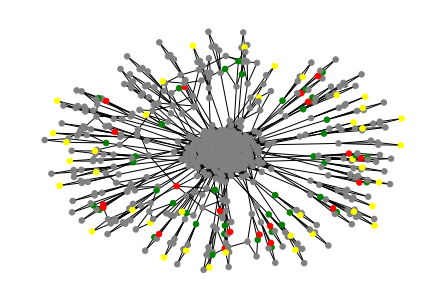

In [117]:
pos = nx.spring_layout(ba_shapes, seed=42)
nx.draw(ba_shapes, pos, node_color=color_list, node_size=30)

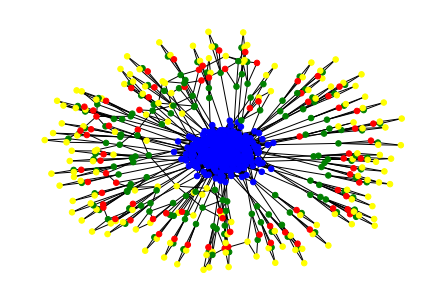

In [118]:
pos = nx.spring_layout(ba_shapes, seed=42)
color_dict = {0:"blue", 1:"green", 2:"yellow", 3:"red"}
nx.draw(ba_shapes, pos, node_color=[color_dict[i] for i in role_ids], node_size=30)

# GNN Explainer
https://github.com/RexYing/gnn-model-explainer/blob/master/explainer/explain.py <br>
https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gnn_explainer_ba_shapes.py <br>
https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gnn_explainer.py

In [119]:
from torch_geometric.nn import GNNExplainer, GCN

In [121]:
data = data.to("cpu")
idx = torch.arange(data.num_nodes)
train_idx, test_idx = train_test_split(idx, train_size=0.8, stratify=data.y)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GCN(data.num_node_features, hidden_channels=20, num_layers=3,
            out_channels=np.unique(y).shape[0], normalize=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=-1)

    train_correct = int((pred[train_idx] == data.y[train_idx]).sum())
    train_acc = train_correct / train_idx.size(0)

    test_correct = int((pred[test_idx] == data.y[test_idx]).sum())
    test_acc = test_correct / test_idx.size(0)

    return train_acc, test_acc


for epoch in range(1, 6001):
    loss = train()
    if epoch % 200 == 0:
        train_acc, test_acc = test()
        print(f'Epoch: {epoch:04d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 0200, Loss: 0.7707, Train: 0.6429, Test: 0.6571
Epoch: 0400, Loss: 0.6858, Train: 0.7589, Test: 0.8071
Epoch: 0600, Loss: 0.6345, Train: 0.6500, Test: 0.6500
Epoch: 0800, Loss: 0.5676, Train: 0.7625, Test: 0.8071
Epoch: 1000, Loss: 0.5459, Train: 0.7696, Test: 0.8071
Epoch: 1200, Loss: 0.5225, Train: 0.7732, Test: 0.8357
Epoch: 1400, Loss: 2.9378, Train: 0.4536, Test: 0.4500
Epoch: 1600, Loss: 0.5013, Train: 0.8054, Test: 0.8357
Epoch: 1800, Loss: 0.4370, Train: 0.8107, Test: 0.8357
Epoch: 2000, Loss: 0.4086, Train: 0.8411, Test: 0.8500
Epoch: 2200, Loss: 0.3855, Train: 0.8839, Test: 0.9000
Epoch: 2400, Loss: 0.3648, Train: 0.8839, Test: 0.8643
Epoch: 2600, Loss: 0.3466, Train: 0.8946, Test: 0.8786
Epoch: 2800, Loss: 0.2773, Train: 0.9143, Test: 0.9143
Epoch: 3000, Loss: 0.2251, Train: 0.9518, Test: 0.9429
Epoch: 3200, Loss: 0.1739, Train: 0.9571, Test: 0.9500
Epoch: 3400, Loss: 0.1502, Train: 0.9625, Test: 0.9500
Epoch: 3600, Loss: 0.1376, Train: 0.9625, Test: 0.9571
Epoch: 380

### Single Explanation

In [122]:
from tqdm import tqdm
from torch_geometric.utils import k_hop_subgraph

Explain node 554: 100%|█████████████████████| 300/300 [00:01<00:00, 207.93it/s]


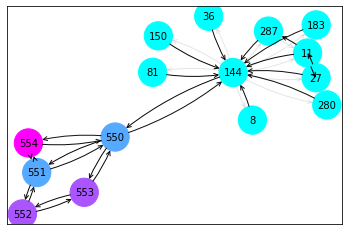

In [123]:
explainer = GNNExplainer(model, epochs=300, return_type='log_prob')
node_idx = 554
node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y=data.y)
plt.show()

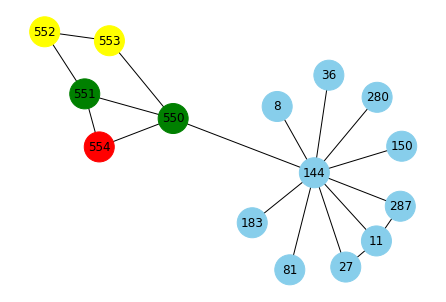

In [124]:
res = k_hop_subgraph(554, num_hops=3, edge_index=data.edge_index)[0].cpu().numpy()
pos = nx.spring_layout(ba_shapes.subgraph(res), seed=42)
color_dict = {0:"skyblue", 1:"green", 2:"yellow", 3:"red"}
nx.draw(ba_shapes.subgraph(res), pos, node_color=np.array([color_dict[i] for i in role_ids])[list(ba_shapes.subgraph(res).nodes)], 
        node_size=900, with_labels=True)

Explain node 320: 100%|█████████████████████| 300/300 [00:01<00:00, 177.30it/s]


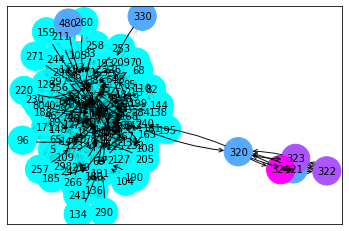

In [128]:
node_idx = 320
node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y=data.y)
plt.show()

Explain node 323: 100%|█████████████████████| 300/300 [00:01<00:00, 253.33it/s]


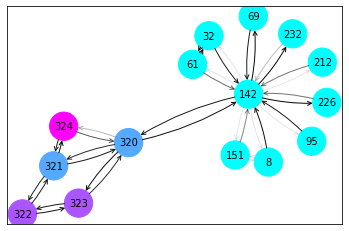

In [129]:
node_idx = 323
node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y=data.y)
plt.show()

### Test Set Explanations

In [130]:
from sklearn.metrics import roc_auc_score

In [131]:
model.eval()
targets, preds = [], []
expl = GNNExplainer(model, epochs=300, return_type='raw', log=False)
# Explanation ROC AUC over all test nodes:
self_loop_mask = data.edge_index[0] != data.edge_index[1]
edge_labels = ((data.edge_index[0] > 300) & (data.edge_index[1] > 300)).long()
for node_idx in tqdm(test_idx.view(-1).tolist()):
    _, expl_edge_mask = expl.explain_node(node_idx, data.x, data.edge_index)
    subgraph = k_hop_subgraph(node_idx, num_hops=3, edge_index=data.edge_index)
    expl_edge_mask = expl_edge_mask[self_loop_mask]
    subgraph_edge_mask = subgraph[3][self_loop_mask]
    targets.append(edge_labels[subgraph_edge_mask].cpu())
    preds.append(expl_edge_mask[subgraph_edge_mask].cpu())

auc = roc_auc_score(torch.cat(targets), torch.cat(preds))
print(f'Mean ROC AUC: {auc:.4f}')

100%|████████████████████████████████████████| 140/140 [03:59<00:00,  1.71s/it]

Mean ROC AUC: 0.5040
